In [222]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [223]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles;
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices
# des sommets d'un element triangle, dans le sens antihoraire.
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ;
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2));
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ;
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1
                coordinates[p,0] = x[i,0]
                coordinates[p,1] = x[j,0]
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1
                    p3 = p1 + n
                    p4 = p2 + n
                    e = e + 1
                    elements3[e,0] = p1
                    elements3[e,1] = p2
                    elements3[e,2] = p3
                    e = e + 1
                    elements3[e,0] = p4
                    elements3[e,1] = p3
                    elements3[e,2] = p2
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j

    return coordinates, elements3,dirichlet, neumann

In [224]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [225]:
def raideurElem(coordinates, T) :

    T = [coordinates[T[i]] for i in range(3)]

    alpha = (T[1][0] - T[0][0]) * (T[2][1] - T[0][1]) - (T[1][1] - T[0][1]) * (T[2][0] - T[0][0])
    gradEta = [[T[(j + 1) % 3][1] - T[(j + 2) % 3][1],
                T[(j + 2) % 3][0] - T[(j + 1) % 3][0]] for j in range(3)] /alpha
    gradEta = np.array(gradEta)
    aire = alpha/2
    M = aire * np.dot(gradEta, np.transpose(gradEta))

    return M

In [226]:
def raideur(n, coordinates, elements3) :
    A = np.zeros((n*n,n*n))
    for e in elements3 :
        M = raideurElem(coordinates, e)
        for i, elt_i in enumerate(e) :  #enumerate(e): pour trouver l'indice, puis la valeur
            for j, elt_j in enumerate(e) :
                A[elt_i, elt_j] += M[i][j]

    return A

In [227]:
def secondMembreElem(n, coordinates, E, A, ud, f, frontiere) :
    bElem = np.zeros(len(E))
    Ecoordinates = [coordinates[E[i]] for i in range(len(E))]

    if (len(E)) == 3 :
        alpha = (Ecoordinates[1][0] - Ecoordinates[0][0]) * (Ecoordinates[2][1] - Ecoordinates[0][1]) - (Ecoordinates[1][1] - Ecoordinates[0][1]) * (Ecoordinates[2][0] - Ecoordinates[0][0])
    elif (len(E)) == 4 :
        Jacobien = np.array([[Ecoordinates[1][0]-Ecoordinates[0][0], Ecoordinates[3][0]-Ecoordinates[0][0]],
                         [Ecoordinates[1][1]-Ecoordinates[0][1], Ecoordinates[3][1]-Ecoordinates[0][1]]])
        alpha = Jacobien[0][0] * Jacobien[1][1] - Jacobien[0][1] * Jacobien[1][0]

    xg, yg = sum(Ecoordinates)/len(E)


    for i,e in enumerate(E) :
        if (len(E)) == 3 :
            terme1 = alpha*f(xg,yg)/6
        elif (len(E)) == 4 :
            terme1 = alpha*f(xg,yg)/4

        terme2 = sum(ud * frontiere * A[e])

        bElem[i] = terme1 - terme2

    return bElem

In [228]:
def bNeuman(n, indNeumann, coordinates) :
    def neumann(x, y) :
        return 0
    b = np.zeros(n*n)
    for e in indNeumann :
        print(e)
        l = np.linalg.norm(coordinates[e[0]] - coordinates[e[1]])
        g = (coordinates[e[0]] + coordinates[e[1]]) / 2
        print(g[0], g[1])
        x = g[0]
        y = g[1]
        b[indNeumann[0]] += l * neumann(x, y) / 2
        b[indNeumann[1]] += l * neumann(x, y) / 2
    return b

In [229]:
def secondMembre(n, coordinates, A, ud, f, elements3) :
    frontiere = np.zeros(n*n)
    for i in range(n*n) :
        if i <= n or i%n == 0 or i%n == n-1 or i >= (n-1) * n:
            frontiere[i] = 1
    b = np.zeros(n*n)
    for e in elements3 :
        bElem = secondMembreElem(n, coordinates, e, A, ud, f, frontiere)
        for i, elem in enumerate(e) :
            b[elem] += bElem[i]
    return b

In [230]:
def reduireA(A, dirichlet) :
    c = 0
    for i in dirichlet :
        i = i[0]
        A = np.array(A)
        if i == 0 :
            A = A[1:, 1:]
        else :
            A = np.concatenate((A[:i + c], A[i + c + 1:]), 0)
            A = np.concatenate((A[:, :i + c], A[:, i + c + 1:]), 1)
        c -= 1
    return A

In [231]:
def reduireB(b, dirichlet) :
    c = 0
    for i in dirichlet :
        i = i[0]
        b = np.array(b)
        if i == 0 :
            b = b[1::]
        else :
            b = np.concatenate((b[:i + c], b[i + c + 1:]), 0)
        c -= 1
    return b

In [232]:
def f(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def u(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y) / (2 * np.pi**2)

In [233]:
def rassembler(dirichlet, ud, x, n) :
    sol = np.zeros((n*n))
    c = 0
    for i in range(n*n) :
        if i in dirichlet :
            c += 1
            sol[i] = ud[i]
        else :
            sol[i] = x[i - c]
    return sol

In [234]:
def solve(n, ud) :
    coordinates, elements3, dirichlet, neumann = maillage(n)
    dirichlet = np.sort(dirichlet, 0)

    A = raideur(n, coordinates, elements3)
    #ud = np.zeros(n*n)
    b = secondMembre(n, coordinates, A, ud, f, elements3)
    Ared = reduireA(A, dirichlet)
    bred = reduireB(b, dirichlet)

    x = np.linalg.solve(Ared, np.transpose(bred))
    sol = rassembler(dirichlet, ud, x, n)

    theorique = [u(p[0], p[1]) for p in coordinates]

    return sol, theorique, coordinates

In [235]:
def erroPlot(r) :
    err = []
    for i in range(r) :
        n = i + 3
        ud = np.zeros(n*n)
        sol, theorique, coordinates = solve(n, ud)
        err += [np.linalg.norm(theorique - sol)]
    plt.plot(err)
    show(coordinates,sol)

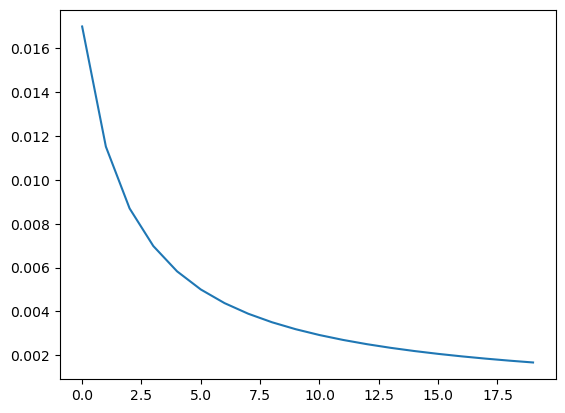

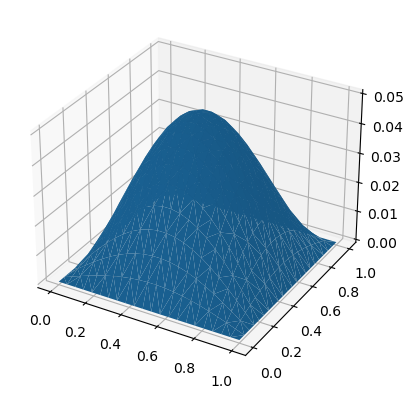

In [236]:

erroPlot(20)

L'erreur vaut
 0.0007163344168002372


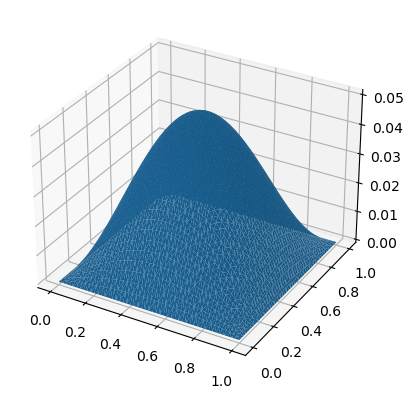

In [237]:
n = 50
coordinates, elements3, dirichlet, neumann = maillage(n)
dirichlet = np.sort(dirichlet, 0)

A = raideur(n, coordinates, elements3)
ud = np.zeros(n*n)
b = secondMembre(n, coordinates, A, ud, f, elements3)
Ared = reduireA(A, dirichlet)
bred = reduireB(b, dirichlet)
#print("La matrice A réduite est\n", Ared)

x = np.linalg.solve(Ared, np.transpose(bred))
#print("La solution intérieure est\n", x)
sol = rassembler(dirichlet, ud, x, n)
#print("La solution rassemblée est\n", sol)

theorique = [u(p[0], p[1]) for p in coordinates]
#print("La solution théorique est\n", theorique)

print("L'erreur vaut\n", np.linalg.norm(theorique - sol))
#print("La figure de la solution théorique est")
#show(coordinates,theorique)
#print("La figure de la solution est")


show(coordinates,sol)

# Si on augmente n, l'erreur décroit -> plot de l'erreur en fonction de n

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [238]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([1, 5, 2,15,4,6,7,8,9,10,11,0]).astype(int)
# nns=np.array([]).astype(int)
# dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [239]:
def raideurElemQ(Q, coordinates) :

    Q = [coordinates[Q[i]] for i in range(4)]
    Jacobien = np.array([[Q[1][0]-Q[0][0], Q[3][0]-Q[0][0]],
                         [Q[1][1]-Q[0][1], Q[3][1]-Q[0][1]]])
    detJ = Jacobien[0][0] * Jacobien[1][1] - Jacobien[0][1] * Jacobien[1][0]
    prodJaco = np.transpose(Jacobien) * Jacobien
    detProdJaco = prodJaco[0][0] * prodJaco[1][1] - prodJaco[0][1] * prodJaco[1][0]
    InvProdJaco = np.array([[prodJaco[1][1] , - prodJaco[0][1]],
                      [-prodJaco[1][0] , prodJaco[0][0]]])/detProdJaco

    N1 = InvProdJaco[0][0]
    # L'élément 1,2 et l'élément 2,1 de la matrice InvProdJaco sont égales car
    # la matrice est symétrique.
    N2 = InvProdJaco[0][1]
    N4 = InvProdJaco[1][1]

    M = np.array([[2*N1+3*N2+2*N4, N4-2*N1,        -N1-3*N2-N4,       N1-2*N4],
                  [N4-2*N1,        2*N1-3*N2+2*N4, N1-2*N4,           -N1+3*N2+N4],
                  [-N1-3*N2-N4,    N1-2*N4,        2*N1+3*N2+2*N4,    -2*N1+N4],
                  [N1-2*N4,        -N1+3*N2+N4,    -2*N1+N4,          2*N1-3*N2+2*N4]])

    M = M * detJ/6

    return M






In [240]:
def raideurQ(n, coordinates, elements4) :
    A = np.zeros((n*n,n*n))
    for e in elements4 :
        M = raideurElemQ(e, coordinates)
        for i, elt_i in enumerate(e) :  #enumerate(e): pour trouver l'indice, puis la valeur
            for j, elt_j in enumerate(e) :
                A[elt_i, elt_j] += M[i][j]

    return A

16
[4 5]
1.0 0.5683333333333349
[5 6]
1.0 0.833333333333335
[0 1]
0.166666666666665 0.0
[1 2]
0.43333333333333 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L'erreur vaut
 0.11797081658188927
La figure de la solution théorique est


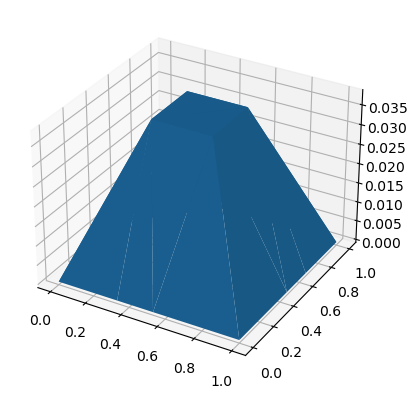

La figure de la solution est


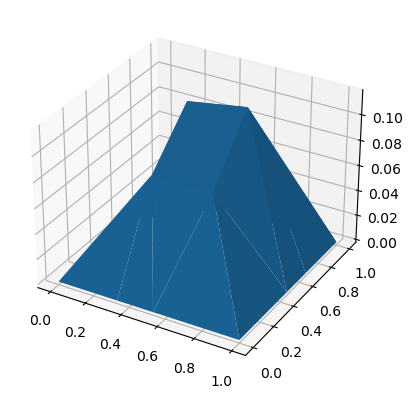

In [241]:
n = int(np.sqrt(len(ccs)))
# coordinates, elements3, dirichlet, neumann = maillage(n)
# dirichlet = np.sort(dirichlet, 0)


A = raideurQ(n, ccs, e4)
A = A + raideur(n, ccs, e3)

ud = np.zeros(n*n)

b = secondMembre(n, ccs, A, ud, f, e3)
b += secondMembre(n, ccs, A, ud, f, e4)
print(b.size)
bn = bNeuman(n, nns, ccs)
print(bn)
b += bn


Ared = reduireA(A, [dds])
bred = reduireB(b, [dds])
#print("La matrice A réduite est\n", Ared)

x = np.linalg.solve(Ared, np.transpose(bred))
#print("La solution intérieure est\n", x)
sol = rassembler(dds, ud, x, n)
#print("La solution rassemblée est\n", sol)

theorique = [u(p[0], p[1]) for p in ccs]
#print("La solution théorique est\n", theorique)

print("L'erreur vaut\n", np.linalg.norm(theorique - sol))
print("La figure de la solution théorique est")
show(ccs,theorique)
print("La figure de la solution est")


show(ccs,sol)

**Compléments  :  un nouveau terme dans l'EDP**